In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
import os
import seaborn as sns
import numpy as np
import seaborn as sns
from sklearn.model_selection import KFold
from mgwr.gwr import GWR
from sklearn.metrics import pairwise_distances
from libpysal.weights.util import full2W
from esda.moran import Moran
from libpysal.weights import DistanceBand
from esda.moran import Moran
from sklearn.cluster import KMeans
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from mgwr.gwr import GWR
from sklearn.cluster import KMeans
import libpysal
from mgwr.sel_bw import Sel_BW

In [2]:
twt_entry = pd.read_csv('data/card_22/22_twt_entries.csv',skiprows=2)
twt_exit = pd.read_csv('data/card_22/22_twt_exits.csv',skiprows=2)

In [3]:
stations_with_poi = gpd.read_file('data/stations_with_poi.geojson')
stations = stations_with_poi.drop(columns=["cluster_ratio"])

In [4]:
ratio_cluster = gpd.read_file('data/cluster/stations_ratio_4.geojson')
rho_cluster = gpd.read_file('data/cluster/stations_rho_4.geojson')

In [5]:
stations_rho_cluster = stations.merge(
    rho_cluster[['NLC', 'cluster_rho']],
    on='NLC',
    how='left'  # 或者 'inner'，取决于你是否只保留两边都有的 NLC
)

In [6]:
variables = [
    "Residential", "Employment", "Commercial", "Catering", "Leisure",
    "Sport", "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"
]

anova_results = []

for var in variables:
    # 按聚类分组，取每组的变量值
    groups = [
        group[var].dropna().values
        for _, group in stations_rho_cluster.groupby("cluster_rho")
    ]
    # 执行 ANOVA
    F, p = f_oneway(*groups)
    anova_results.append({
        "Variable": var,
        "F_statistic": F,
        "p_value": p
    })

# 转为表格
anova_df = pd.DataFrame(anova_results)
anova_df["significant_0.05"] = anova_df["p_value"] < 0.05
anova_df["significant_0.01"] = anova_df["p_value"] < 0.01

# 排序查看结果
anova_df = anova_df.sort_values(by="F_statistic", ascending=False)

In [7]:
anova_df

,Variable,F_statistic,p_value,significant_0.05,significant_0.01
1,Employment,39.264198,3.804337e-33,True,True
7,Education,28.197536,1.086708e-24,True,True
3,Catering,18.764095,7.284540e-17,True,True
10,Attraction,18.637386,9.367865e-17,True,True
6,Medical,15.759076,3.037922e-14,True,True
8,Hotel,15.455817,5.628359e-14,True,True
4,Leisure,12.675541,1.711282e-11,True,True
2,Commercial,11.676098,1.372197e-10,True,True
9,Park,10.514084,1.568189e-09,True,True
5,Sport,4.337654,7.337534e-04,True,True


In [8]:
# 按 cluster_ratio 分组，对各类 POI 列求和
cluster_rho_summary = stations_rho_cluster.groupby("cluster_rho")[
    ["Residential", "Employment", "Commercial", "Catering", "Leisure", "Sport",
     "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"]
].sum()

In [9]:
import matplotlib.patches as mpatches
# 你提供的 POI 类型顺序
poi_types = [
    "Residential","Employment", "Commercial", "Catering", "Leisure", "Sport",
    "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"
]
# ✅ 创建颜色映射（可按需求换）
poi_colors = {
    "Residential": "#8dd3c7",
    "Employment": "#ffffb3",
    "Commercial": "#bebada",
    "Catering": "#fb8072",
    "Leisure": "#80b1d3",
    "Sport": "#fdb462",
    "Medical": "#b3de69",
    "Education": "#fccde5",
    "Hotel": "#d9d9d9",
    "Park": "#bc80bd",
    "Attraction": "#ccebc5",
    "Busstop": "#ffed6f"
}

# 手动生成 legend 标签项
legend_elements = [
    mpatches.Patch(facecolor=color, edgecolor='white', label=label)
    for label, color in poi_colors.items()
]

# ✅ 计算比例
df_rho = cluster_rho_summary[poi_types].div(cluster_rho_summary[poi_types].sum(axis=1), axis=0)

In [11]:
from matplotlib.colors import to_rgb
def _auto_text_color(hex_color: str) -> str:
    """
    根据填充色自动选择黑/白字，避免看不清。
    使用感知亮度 (Y = 0.2126 R + 0.7152 G + 0.0722)。
    """
    r, g, b = to_rgb(hex_color)
    y = 0.2126 * r + 0.7152 * g + 0.0722 * b
    return 'black' if y > 0.6 else 'white'

def plot_stacked_bar(
    df,
    poi_types,
    poi_colors,
    exclude_poi=None,
    legend_loc='bottom',          # 'bottom' 或 'right'
    figsize=(14, 8),
    title='',
    bar_width=0.3,
    label_min=0.02,               # 小于该占比不标注
    label_fmt='{:.0%}',           # 百分比格式
    auto_contrast=True            # 自动选择黑/白字体
):
    """
    df: 行为 cluster，列为各 POI，值为占比（行内和为1）
    poi_types: 要绘制的列名顺序列表
    poi_colors: dict, {poi: '#RRGGBB'}
    exclude_poi: 可选，排除的 poi 名称列表
    """

    # 过滤列
    if exclude_poi:
        poi_types = [p for p in poi_types if p not in exclude_poi]
    df_use = df[poi_types].copy()

    sns.set(style='whitegrid')
    fig, ax = plt.subplots(figsize=figsize)

    x = np.arange(len(df_use))
    bottom = np.zeros(len(df_use))

    # 逐段堆叠
    for poi in poi_types:
        heights = df_use[poi].values
        color = poi_colors.get(poi, '#999999')

        bars = ax.bar(
            x,
            heights,
            bottom=bottom,
            label=poi,
            color=color,
            edgecolor='white',
            linewidth=0.6,
            width=bar_width
        )

        # 段内文字标注
        for xi, h, b in zip(x, heights, bottom):
            if h >= label_min:
                txt_color = _auto_text_color(color) if auto_contrast else 'black'
                ax.text(
                    xi,
                    b + h / 2,
                    label_fmt.format(h),
                    ha='center',
                    va='center',
                    fontsize=10,
                    color=txt_color
                )

        bottom += heights  # 注意在循环末尾更新

    # 轴与标题
    ax.set_ylabel("Proportion", fontsize=12)
    ax.set_xlabel("Functional Cluster", fontsize=12)
    ax.set_title(title or "Functional Composition of Each Cluster",
                 fontsize=15, pad=15)
    ax.set_ylim(0, 1.05)
    ax.set_xticks(x)
    ax.set_xticklabels([f'Cluster {i+1}' for i in range(len(df_use))], fontsize=11)
    ax.tick_params(axis='y', labelsize=10)
    ax.set_facecolor("#f9f9f9")

    # 图例
    if legend_loc == 'bottom':
        ax.legend(
            loc='upper center',
            bbox_to_anchor=(0.5, -0.12),
            ncol=min(6, len(poi_types)),
            frameon=False,
            fontsize=12
        )
        plt.subplots_adjust(bottom=0.25)
    elif legend_loc == 'right':
        ax.legend(
            loc='center left',
            bbox_to_anchor=(1.01, 0.5),
            frameon=False,
            fontsize=12
        )
        plt.subplots_adjust(right=0.78)

    plt.tight_layout()
    plt.show()


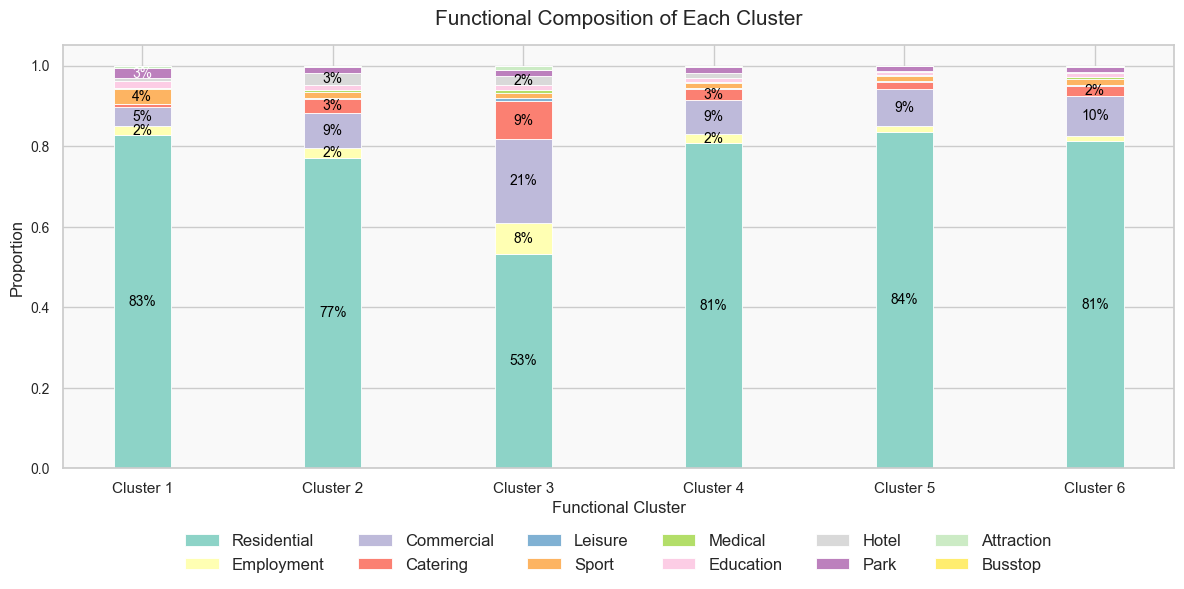

In [12]:
plot_stacked_bar(
    df = df_rho,
    poi_types=[
        "Residential", "Employment", "Commercial", "Catering", "Leisure", "Sport",
        "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"
    ],
    poi_colors=poi_colors,
    exclude_poi=None,  # 可选，若不排除则改为 None
    legend_loc='bottom',
    figsize=(12, 6)
)

In [13]:
# 合并 AM Peak 进站数据
# 确保 NLC 字段都是字符串格式
twt_entry['NLC'] = twt_entry['NLC'].astype(str)
twt_exit['NLC'] = twt_exit['NLC'].astype(str)
stations['NLC'] = stations['NLC'].astype(str)

# 清理列名：去除列名中多余的空格
twt_entry.columns = twt_entry.columns.str.strip()
twt_exit.columns = twt_exit.columns.str.strip()

# 合并 AM / PM 进站数据（来自 entry 文件）
stations_rg = stations_rho_cluster.merge(
    twt_entry[['NLC', 'AM Peak', 'PM Peak','Total']].rename(columns={
        'AM Peak': 'am_entry_twt',
        'PM Peak': 'pm_entry_twt',
        'Total':'tot_entry_twt'
    }),
    on='NLC',
    how='left'
)

# 合并 AM / PM 出站数据（来自 exit 文件）
stations_rg = stations_rg.merge(
    twt_exit[['NLC', 'AM Peak', 'PM Peak','Total']].rename(columns={
        'AM Peak': 'am_exit_twt',
        'PM Peak': 'pm_exit_twt',
        'Total':'tot_exit_twt'
    }),
    on='NLC',
    how='left'
)

stations_rg['am_entry_ratio'] = stations_rg['am_entry_twt'] / stations_rg['tot_entry_twt']
stations_rg['pm_entry_ratio'] = stations_rg['pm_entry_twt'] / stations_rg['tot_entry_twt']
stations_rg['am_exit_ratio'] = stations_rg['am_exit_twt'] / stations_rg['tot_exit_twt']
stations_rg['pm_exit_ratio'] = stations_rg['pm_exit_twt'] / stations_rg['tot_exit_twt']

In [14]:
stations_rg[['am_entry_ratio', 'pm_entry_ratio', 'am_exit_ratio', 'pm_exit_ratio']].describe()

,am_entry_ratio,pm_entry_ratio,am_exit_ratio,pm_exit_ratio
count,431.000000,431.000000,431.000000,431.000000
mean,0.303940,0.233327,0.209678,0.294276
std,0.118355,0.083635,0.096947,0.070566
min,0.020170,0.086259,0.059972,0.119944
25%,0.229641,0.169149,0.137910,0.251171
50%,0.327335,0.218657,0.190246,0.297141
75%,0.392765,0.285978,0.268399,0.346572
max,0.560602,0.478712,0.537294,0.462037


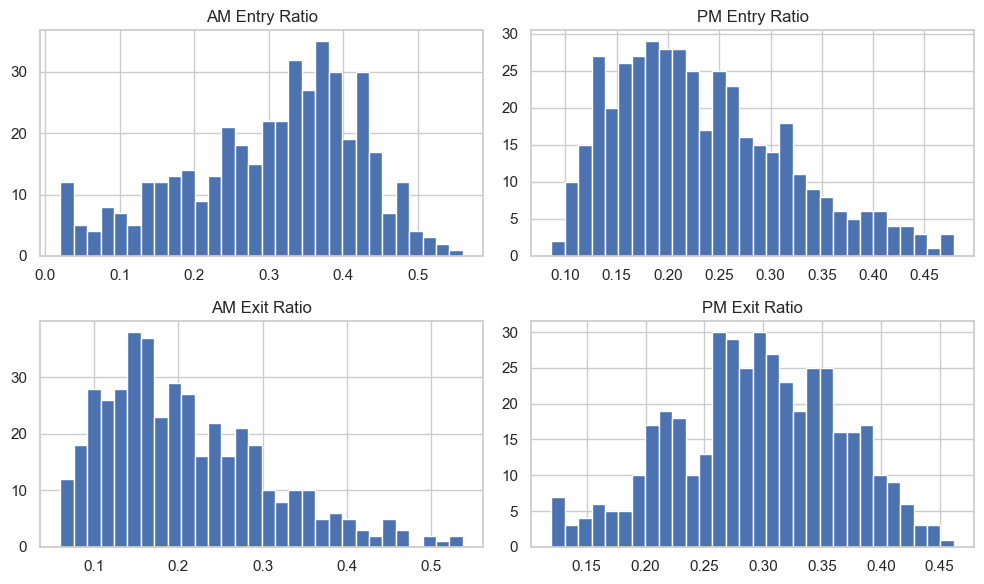

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

stations_rg['am_entry_ratio'].hist(ax=axs[0, 0], bins=30)
axs[0, 0].set_title('AM Entry Ratio')

stations_rg['pm_entry_ratio'].hist(ax=axs[0, 1], bins=30)
axs[0, 1].set_title('PM Entry Ratio')

stations_rg['am_exit_ratio'].hist(ax=axs[1, 0], bins=30)
axs[1, 0].set_title('AM Exit Ratio')

stations_rg['pm_exit_ratio'].hist(ax=axs[1, 1], bins=30)
axs[1, 1].set_title('PM Exit Ratio')

plt.tight_layout()
plt.show()

In [16]:
import statsmodels.api as sm
reg_df = stations_rg.copy() #stations_rg_capped
X = reg_df[["Residential", "Employment", "Commercial", "Leisure", "Sport",
            "Medical", "Education", "Hotel", "Park", "Attraction", "Busstop"]]
X = sm.add_constant(X)
y = reg_df['am_entry_ratio']
#y_logit = np.log(y)
#model = sm.OLS(y, X).fit()
model = sm.OLS(y, X).fit(cov_type='HC3')

In [17]:
from statsmodels.stats.diagnostic import het_breuschpagan

# 需要残差和自变量 X
resid = model.resid
exog = model.model.exog  # 注意：这里用的是 design matrix
bp_test = het_breuschpagan(resid, exog)

labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
dict(zip(labels, bp_test))

{'Lagrange multiplier statistic': 11.512259793292143,
 'p-value': 0.401397333729065,
 'f-value': 1.0453522217386764,
 'f p-value': 0.40515523247665924}

In [ ]:
def plot_ols_diagnostics_combined(ols_results):
    fitted = ols_results.fittedvalues
    resid = ols_results.resid
    infl = OLSInfluence(ols_results)
    std_resid = infl.resid_studentized_internal

    # 创建一张 2×2 大图
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    # === 1. Residuals vs Fitted ===
    ax1 = axes[0]
    ax1.scatter(fitted, resid, s=18, alpha=0.85)
    z = np.polyfit(fitted, resid, 2)
    xs = np.linspace(fitted.min(), fitted.max(), 200)
    ax1.plot(xs, np.polyval(z, xs), linestyle="-.", linewidth=1)
    ax1.axhline(0, linestyle="--", linewidth=1)
    ax1.set_title("Residuals vs Fitted",fontsize=17)
    ax1.set_xlabel("Fitted values")
    ax1.set_ylabel("Residuals")

    # === 2. Q–Q Plot ===
    sm.qqplot(std_resid, line="45", fit=True, ax=axes[1])
    axes[1].set_title("Normal Q–Q (Std Residuals)",fontsize=17)

    # === 3. Scale–Location ===
    ax3 = axes[2]
    y_sc = np.sqrt(np.abs(std_resid))
    ax3.scatter(fitted, y_sc, s=18, alpha=0.85)
    z2 = np.polyfit(fitted, y_sc, 1)
    ax3.plot(xs, np.polyval(z2, xs), linestyle="-.", linewidth=1)
    ax3.set_xlabel("Fitted values")
    ax3.set_ylabel("√|Standardized Residuals|")
    ax3.set_title("Scale–Location",fontsize=17)

    # === 4. Histogram of Residuals ===
    ax4 = axes[3]
    n, bins, _ = ax4.hist(resid, bins="auto", density=True, alpha=0.6)
    kde = stats.gaussian_kde(resid)
    xs2 = np.linspace(resid.min(), resid.max(), 300)
    ax4.plot(xs2, kde(xs2), linewidth=1.5, label="KDE")
    mu, sd = resid.mean(), resid.std(ddof=1)
    ax4.plot(xs2, stats.norm.pdf(xs2, mu, sd), linestyle="--", linewidth=1, label="Normal PDF")
    ax4.set_xlabel("Residual")
    ax4.set_ylabel("Density")
    ax4.set_title("Residuals Histogram",fontsize=17)
    ax4.legend()

    # 调整布局并保存
    plt.tight_layout()
    plt.show()

    return fig


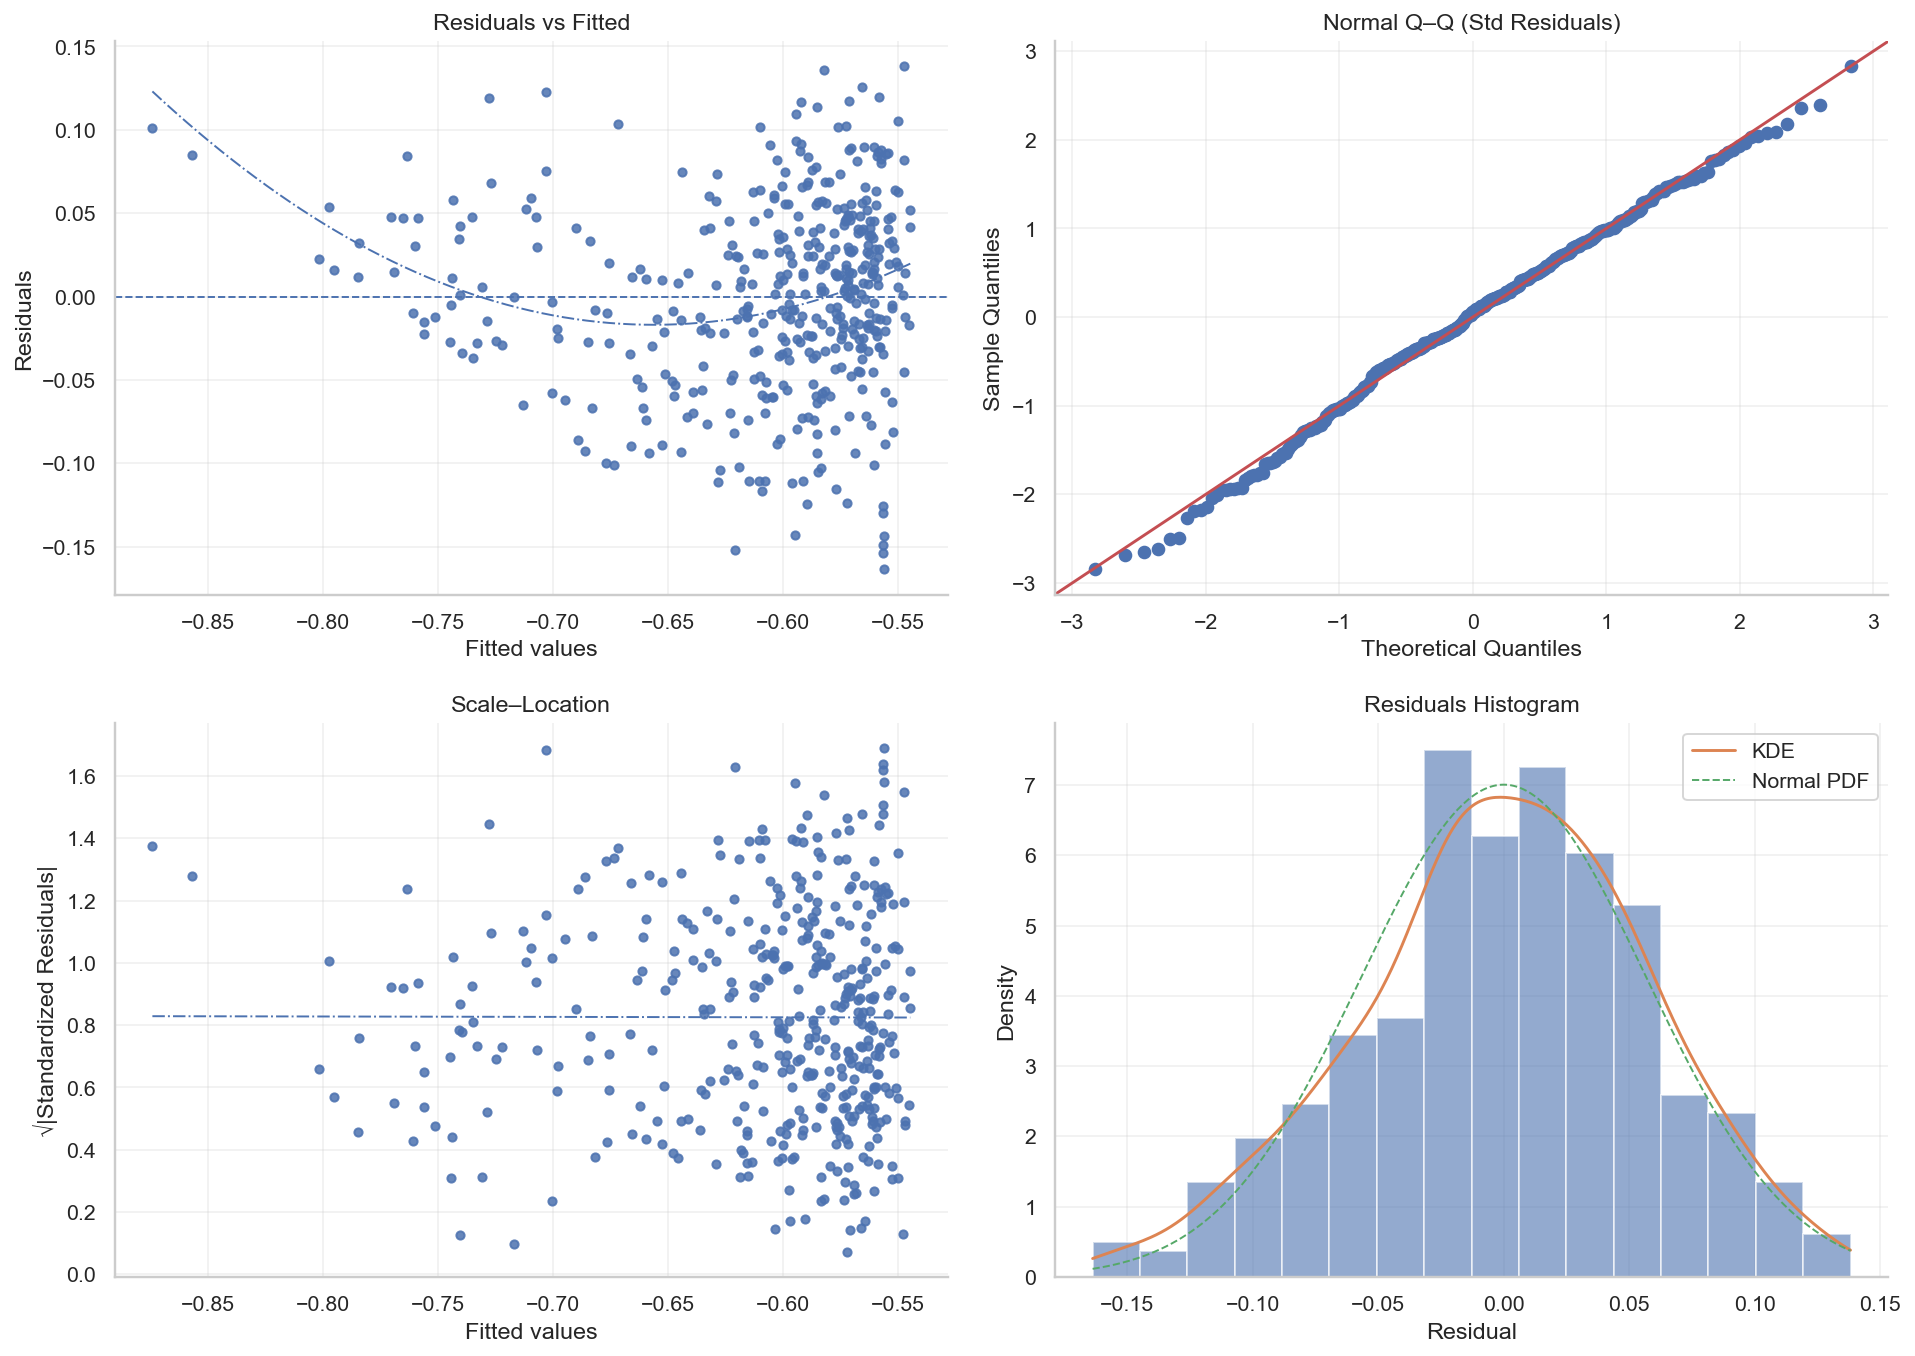

In [26]:
y_bc, lambda_bc = stats.boxcox(y)  # y 必须 > 0
model_bc = sm.OLS(y_bc, sm.add_constant(X)).fit()
fig = plot_ols_diagnostics_combined(model_bc)

In [25]:
reg_df = stations_rg.copy() #stations_rg_capped
# log1p 处理的变量
log_vars = ["Residential", "Employment", "Commercial", "Leisure", "Sport",
            "Medical", "Education", "Hotel", "Park", "Attraction"]
for col in log_vars:
    reg_df[col] = np.log1p(reg_df[col])  # log(1 + x)，避免log(0)
# 特别处理 Busstop 为二值变量
reg_df['Busstop'] = (reg_df['Busstop'] > 0).astype(int)

X = reg_df[log_vars + ['Busstop']]  # 所有变量已按推荐处理
y1 = reg_df['am_entry_ratio']
y1_logit = np.log(y / (1 - y))

In [26]:
from scipy import stats
y1_bc, lambda_bc = stats.boxcox(y)  # y 必须 > 0
y_logit = np.log(y)
print("Best lambda:", lambda_bc)

Best lambda: 1.2745718352109991


In [27]:
model_bc1 = sm.OLS(y1_bc, sm.add_constant(X)).fit()

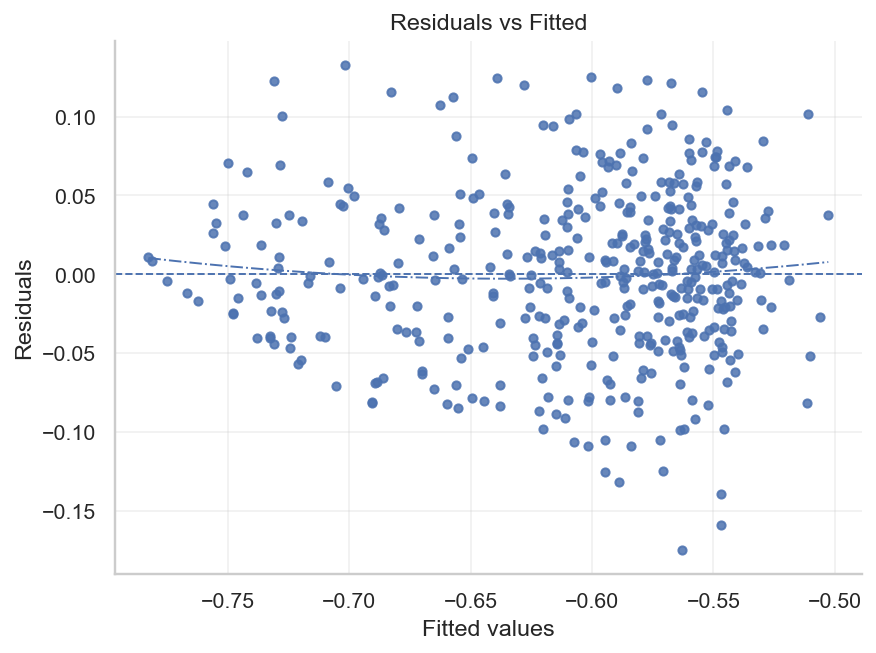

<Figure size 896x672 with 0 Axes>

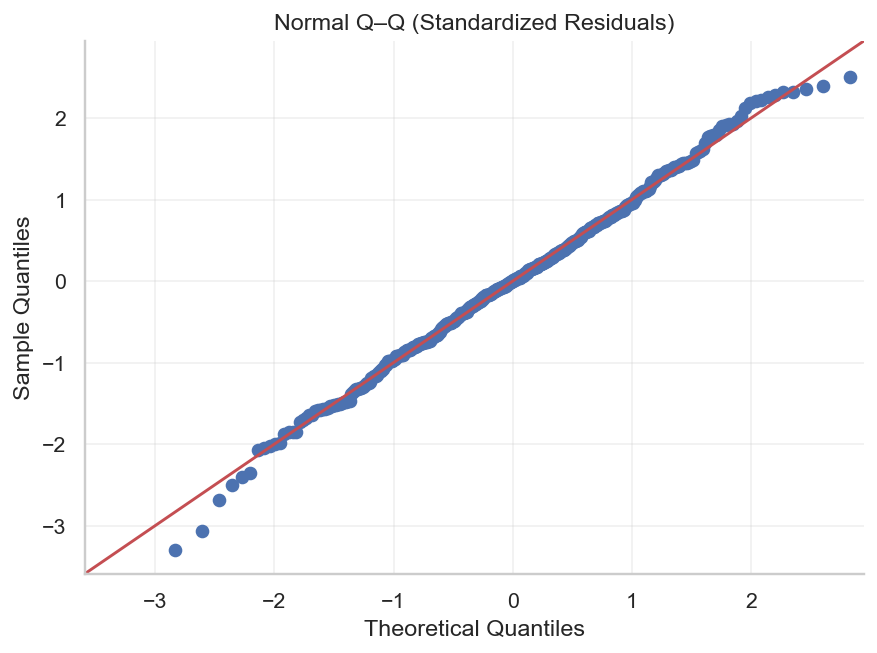

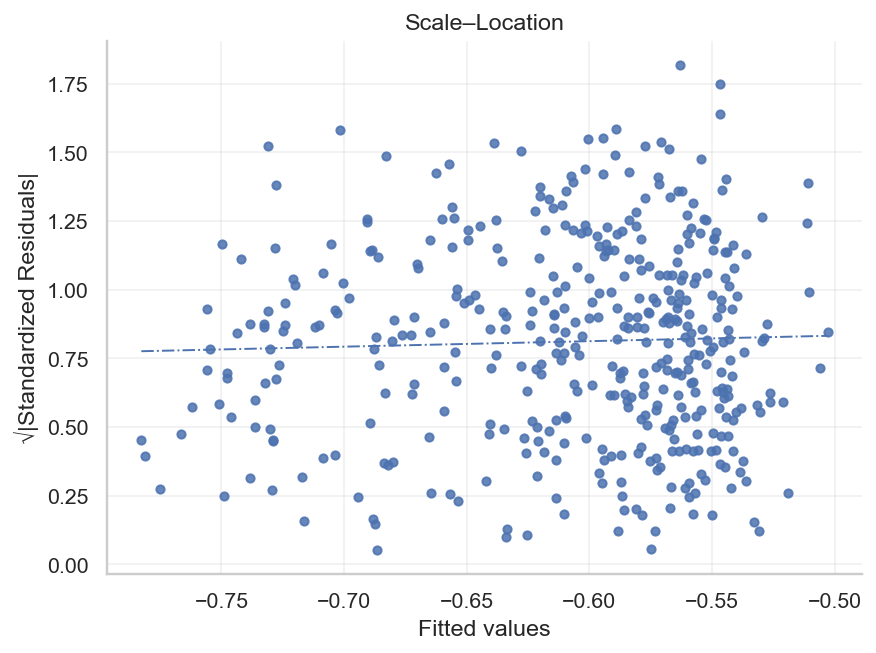

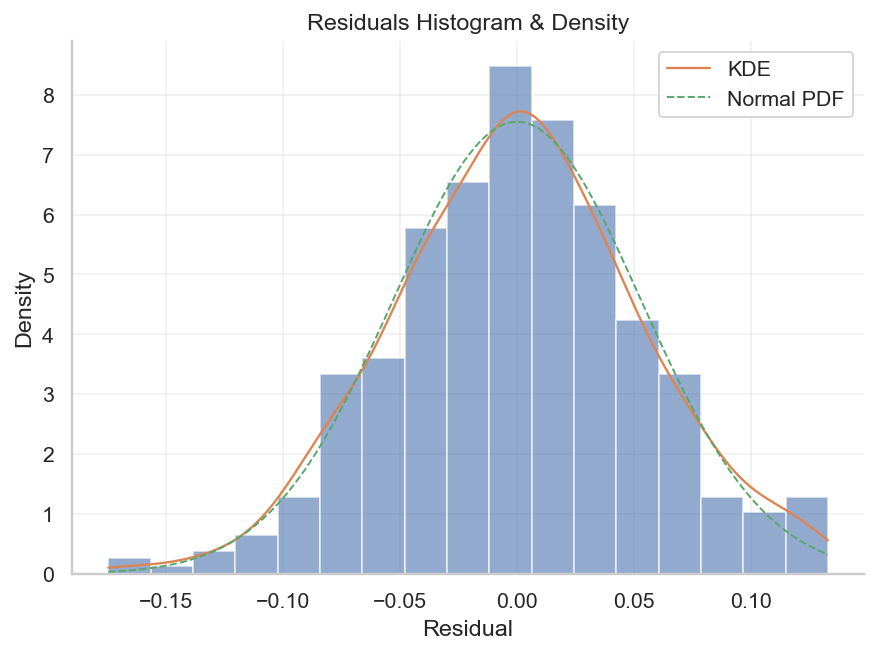

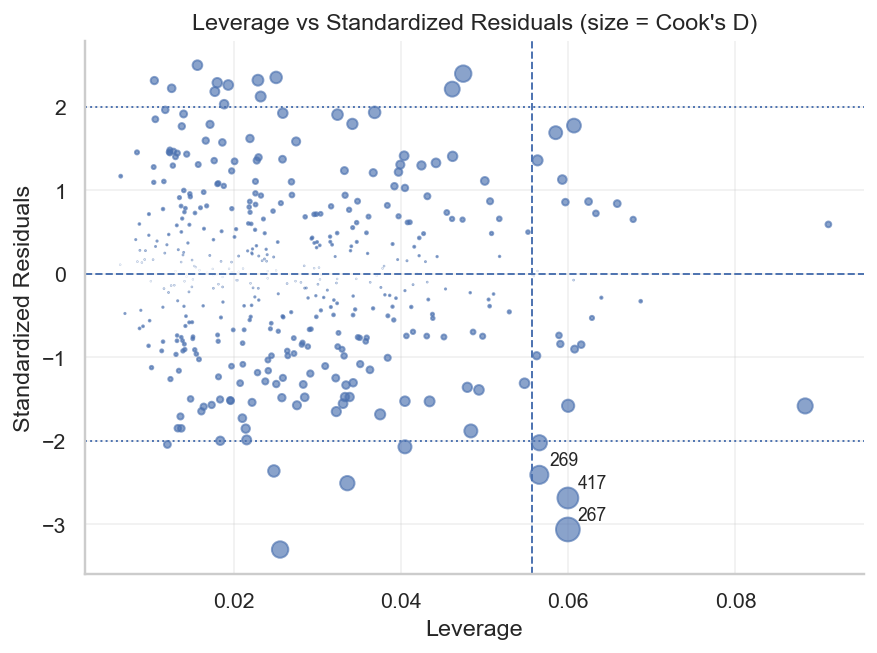

In [28]:
figs = plot_ols_diagnostics(model_bc1)  # 运行后会弹出 5 张图
for name, fig in figs.items():
     fig.savefig(f"{name}.png", bbox_inches="tight")

In [29]:
print(model_bc1.summary())
summary_df1 = model_bc1.summary2().tables[1]  # 更简洁的表格（不含文字）
print(summary_df1)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.579
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     52.45
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           8.24e-72
Time:                        13:31:39   Log-Likelihood:                 656.20
No. Observations:                 431   AIC:                            -1288.
Df Residuals:                     419   BIC:                            -1240.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5287      0.009    -57.153      

In [30]:
import statsmodels.api as sm

def one_vs_rest_logit_table_sig(df, cluster_col, X_cols):
    """
    对 cluster 中的每一类，执行 one-vs-rest 逻辑回归
    仅输出显著变量（P < 0.05）中 p 值最小的前 top_n 个
    """
    clusters = sorted(df[cluster_col].unique())
    output_rows = []

    for c in clusters:
        df[f'is_cluster_{c}'] = (df[cluster_col] == c).astype(int)
        y = df[f'is_cluster_{c}']
        X = sm.add_constant(df[X_cols])
        model = sm.Logit(y, X)
        result = model.fit(disp=0)

        # 构建结果表
        temp_df = pd.DataFrame({
            'POI Type': X_cols,
            'β': [round(result.params[var], 4) for var in X_cols],
            'P': [round(result.pvalues[var], 4) for var in X_cols]
        })

        # 只保留显著变量
        temp_df = temp_df[temp_df['P'] < 0.05]

        # 添加 cluster 信息
        temp_df['Cluster'] = c + 1 # 可改为 c (0–5) 若你想保留原标签
        output_rows.extend(temp_df.to_dict(orient='records'))

    output_df = pd.DataFrame(output_rows)
    return output_df[['Cluster', 'POI Type', 'β', 'P']]

In [31]:
reg_df['cluster_rho'].value_counts()

cluster_rho
2    129
4    109
5     97
1     41
0     30
3     25
Name: count, dtype: int64

In [32]:
from tabulate import tabulate
table = one_vs_rest_logit_table_sig(reg_df, 'cluster_rho', log_vars + ['Busstop'])

# 按 Cluster 和变量顺序排序，输出为论文样式
table = table.sort_values(by=['Cluster', 'POI Type'])

# 可打印为 markdown / LaTeX / plain table 格式
print(tabulate(table, headers='keys', tablefmt='github', showindex=False))

|   Cluster | POI Type    |       β |      P |
|-----------|-------------|---------|--------|
|         2 | Education   |  1.3003 | 0.0014 |
|         2 | Hotel       |  0.5016 | 0.0102 |
|         2 | Park        |  0.6852 | 0.0361 |
|         2 | Residential |  0.5388 | 0.0038 |
|         3 | Attraction  |  0.8155 | 0.0002 |
|         3 | Education   |  0.9957 | 0.0012 |
|         3 | Employment  |  0.6071 | 0.001  |
|         3 | Hotel       |  0.5603 | 0.0005 |
|         3 | Park        |  0.5489 | 0.024  |
|         3 | Residential | -0.312  | 0.015  |
|         4 | Hotel       |  0.6862 | 0.0087 |
|         5 | Education   | -0.7433 | 0.0024 |
|         5 | Hotel       | -1.1534 | 0      |
|         5 | Medical     |  0.6385 | 0.0416 |
|         5 | Park        | -0.4922 | 0.0196 |
|         6 | Hotel       | -0.7228 | 0.0005 |
|         6 | Residential |  0.2881 | 0.0035 |


In [33]:
def one_vs_rest_logit_table_sig_debug(df, cluster_col, X_cols, show_full_summary=False):
    """
    对 cluster 中的每一类，执行 one-vs-rest 逻辑回归
    显示每个聚类的变量显著性检验，输出所有显著变量（P < 0.05）
    """
    clusters = sorted(df[cluster_col].unique())
    output_rows = []

    for c in clusters:
        print(f"\n==== Cluster {c} ====")
        
        # 创建 one-vs-rest 标签列
        df[f'is_cluster_{c}'] = (df[cluster_col] == c).astype(int)
        y = df[f'is_cluster_{c}']
        X = sm.add_constant(df[X_cols])
        
        try:
            model = sm.Logit(y, X)
            result = model.fit(disp=0)

            # 可选：显示完整回归表
            if show_full_summary:
                print(result.summary())

            # 构建结果表
            temp_df = pd.DataFrame({
                'POI Type': X_cols,
                'β': [round(result.params[var], 3) for var in X_cols],
                'P': [round(result.pvalues[var], 3) for var in X_cols]
            })

            print(f"  → Total variables: {len(temp_df)}")
            print(f"  → Significant variables (P < 0.05): {sum(temp_df['P'] < 0.05)}")

            # 只保留显著变量
            temp_df = temp_df[temp_df['P'] < 0.05]

            if temp_df.empty:
                print("  ⚠ No significant variables found for this cluster.")
            else:
                # 添加 cluster 编号（保留原编号）
                temp_df['Cluster'] = c
                output_rows.extend(temp_df.to_dict(orient='records'))

        except Exception as e:
            print(f"  ❌ Logistic regression failed for cluster {c}: {e}")

    output_df = pd.DataFrame(output_rows)
    if output_df.empty:
        print("\n⚠ No clusters had significant variables. Try relaxing the P-value threshold or check your data.")
        return pd.DataFrame(columns=['Cluster', 'POI Type', 'β', 'P'])
    else:
        return output_df[['Cluster', 'POI Type', 'β', 'P']]

In [ ]:
table = one_vs_rest_logit_table_sig_debug(reg_df, 'cluster_rho', log_vars + ['Busstop'])

# 排序后打印
from tabulate import tabulate
table = table.sort_values(by=['Cluster', 'POI Type'])
print(tabulate(table, headers='keys', tablefmt='github', showindex=False))


==== Cluster 0 ====
  → Total variables: 11
  → Significant variables (P < 0.05): 0
  ⚠ No significant variables found for this cluster.

==== Cluster 1 ====
  → Total variables: 11
  → Significant variables (P < 0.05): 4

==== Cluster 2 ====
  → Total variables: 11
  → Significant variables (P < 0.05): 6

==== Cluster 3 ====
  → Total variables: 11
  → Significant variables (P < 0.05): 1

==== Cluster 4 ====
  → Total variables: 11
  → Significant variables (P < 0.05): 4

==== Cluster 5 ====
  → Total variables: 11
  → Significant variables (P < 0.05): 2
|   Cluster | POI Type    |      β |     P |
|-----------|-------------|--------|-------|
|         1 | Education   |  1.3   | 0.001 |
|         1 | Hotel       |  0.502 | 0.01  |
|         1 | Park        |  0.685 | 0.036 |
|         1 | Residential |  0.539 | 0.004 |
|         2 | Attraction  |  0.816 | 0     |
|         2 | Education   |  0.996 | 0.001 |
|         2 | Employment  |  0.607 | 0.001 |
|         2 | Hotel       |  0.5

In [35]:
import statsmodels.api as sm

def backward_elimination_verbose(X, y, threshold_out=0.05):
    """
    后向逐步回归（Backward Elimination），输出每一步筛选详情，并记录 R²。

    参数：
        X: 自变量 dataframe（不含常数项）
        y: 因变量 series
        threshold_out: 移除变量的 p-value 阈值

    返回：
        最终变量列表、每一步记录的 history（包含变量、p 值、R²）
    """
    features = X.columns.tolist()
    step = 0
    history = []

    while True:
        step += 1
        X_const = sm.add_constant(X[features])
        model = sm.OLS(y, X_const).fit()
        pvalues = model.pvalues.iloc[1:]  # 排除截距
        max_pval = pvalues.max()
        worst_feature = pvalues.idxmax()
        r2 = model.rsquared
        adj_r2 = model.rsquared_adj

        print(f"\nStep {step}:")
        print(f"varibles: {features}")
        print(f"max p-value: {max_pval:.6f} ({worst_feature})")
        print(f"R² = {r2:.4f}, Adjusted R² = {adj_r2:.4f}")

        history.append({
            'step': step,
            'variables': features.copy(),
            'removed': worst_feature if max_pval > threshold_out else None,
            'max_pvalue': max_pval,
            'r_squared': r2,
            'adj_r_squared': adj_r2
        })

        if max_pval > threshold_out:
            print(f"→ 移除变量: {worst_feature}")
            features.remove(worst_feature)
        else:
            print("→ 所有变量都显著，停止剔除。")
            break

    return features, pd.DataFrame(history)

In [36]:
# 运行函数
final_features_ae, history_df = backward_elimination_verbose(X, y1_bc)

# 查看保留变量
print("\nam_entry_ratio最终保留变量：", final_features_ae)


Step 1:
varibles: ['Residential', 'Employment', 'Commercial', 'Leisure', 'Sport', 'Medical', 'Education', 'Hotel', 'Park', 'Attraction', 'Busstop']
max p-value: 0.737034 (Sport)
R² = 0.5793, Adjusted R² = 0.5682
→ 移除变量: Sport

Step 2:
varibles: ['Residential', 'Employment', 'Commercial', 'Leisure', 'Medical', 'Education', 'Hotel', 'Park', 'Attraction', 'Busstop']
max p-value: 0.587672 (Busstop)
R² = 0.5792, Adjusted R² = 0.5692
→ 移除变量: Busstop

Step 3:
varibles: ['Residential', 'Employment', 'Commercial', 'Leisure', 'Medical', 'Education', 'Hotel', 'Park', 'Attraction']
max p-value: 0.336356 (Commercial)
R² = 0.5789, Adjusted R² = 0.5699
→ 移除变量: Commercial

Step 4:
varibles: ['Residential', 'Employment', 'Leisure', 'Medical', 'Education', 'Hotel', 'Park', 'Attraction']
max p-value: 0.405804 (Medical)
R² = 0.5780, Adjusted R² = 0.5700
→ 移除变量: Medical

Step 5:
varibles: ['Residential', 'Employment', 'Leisure', 'Education', 'Hotel', 'Park', 'Attraction']
max p-value: 0.029147 (Leisure)
R

In [37]:
X_final = sm.add_constant(X[final_features_ae])
model_final_ae = sm.OLS(y1_bc, X_final).fit()

In [38]:
print(model_final_ae.summary())
summary_df = model_final_ae.summary2().tables[1]  # 更简洁的表格（不含文字）
print(summary_df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     82.52
Date:                Sat, 16 Aug 2025   Prob (F-statistic):           4.18e-75
Time:                        13:33:06   Log-Likelihood:                 655.16
No. Observations:                 431   AIC:                            -1294.
Df Residuals:                     423   BIC:                            -1262.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.5313      0.009    -61.391      